In [68]:
import numpy as np

# Zakres współrzędnych dla Warszawy
# lat_min, lat_max = 52.0, 52.4
# lon_min, lon_max = 20.8, 21.3
# lat_min, lat_max = 52.11, 52.14
# lon_min, lon_max = 21.02, 21.08
lat_min, lat_max = 52.10, 52.16
lon_min, lon_max = 21.01, 21.13

# Ustalmy rozdzielczość siatki
lat_points = np.linspace(lat_min, lat_max, num=10)
lon_points = np.linspace(lon_min, lon_max, num=10)

# Tworzymy siatkę współrzędnych
grid_points = [(lat, lon) for lat in lat_points for lon in lon_points]


In [20]:
import requests
import json
from datetime import datetime

# Funkcja do pobierania danych pogodowych
def get_weather_data(lat, lon, start_date, end_date):
    url = f"https://archive-api.open-meteo.com/v1/era5?latitude={lat}&longitude={lon}&start_date={start_date}&end_date={end_date}&hourly=temperature_2m"
    response = requests.get(url)
    data = response.json()
    return data

# Okres czasu do pobrania danych
start_date = "2021-06-01"
end_date = "2021-06-02"

# Pobieramy dane dla każdej lokalizacji
weather_data = {}
for lat, lon in grid_points:
    weather_data[(lat, lon)] = get_weather_data(lat, lon, start_date, end_date)


In [69]:
# Funkcja do obliczania średniej temperatury
def calculate_average_temperature(data):
    temperatures = data['hourly']['temperature_2m']
    avg_temperature = sum(temperatures) / len(temperatures)
    return avg_temperature

# Przetwarzamy dane, aby uzyskać średnie temperatury
average_temperatures = {}
for (lat, lon), data in weather_data.items():
    average_temperatures[(lat, lon)] = calculate_average_temperature(data)


AttributeError: 'list' object has no attribute 'items'

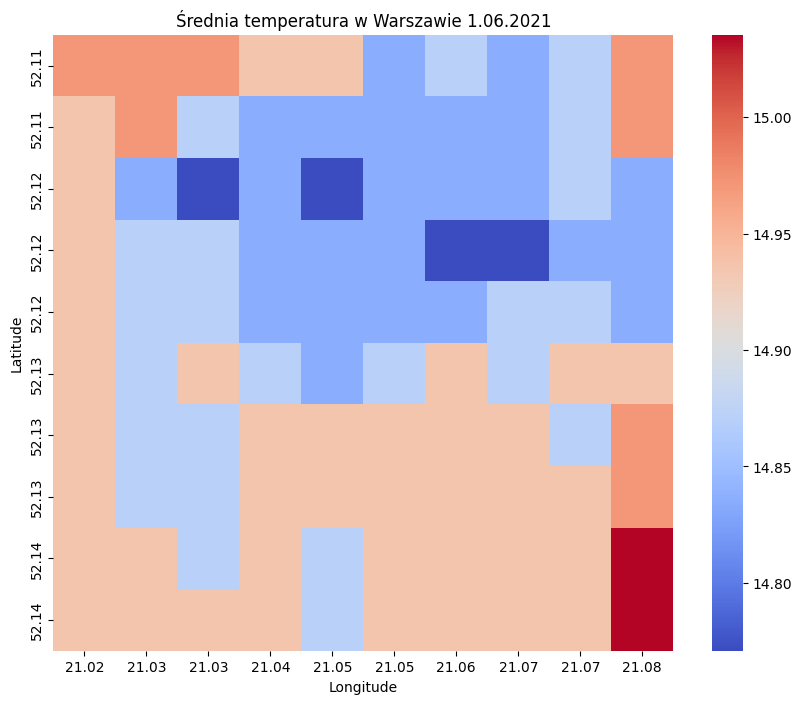

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Przekształcamy dane do formatu tablicowego
heatmap_data = np.zeros((len(lat_points), len(lon_points)))
for i, lat in enumerate(lat_points):
    for j, lon in enumerate(lon_points):
        heatmap_data[i, j] = average_temperatures[(lat, lon)]

# Tworzymy mapę ciepła
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, xticklabels=np.round(lon_points, 2), yticklabels=np.round(lat_points, 2), cmap="coolwarm")
plt.title("Średnia temperatura w Warszawie 1.06.2021")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


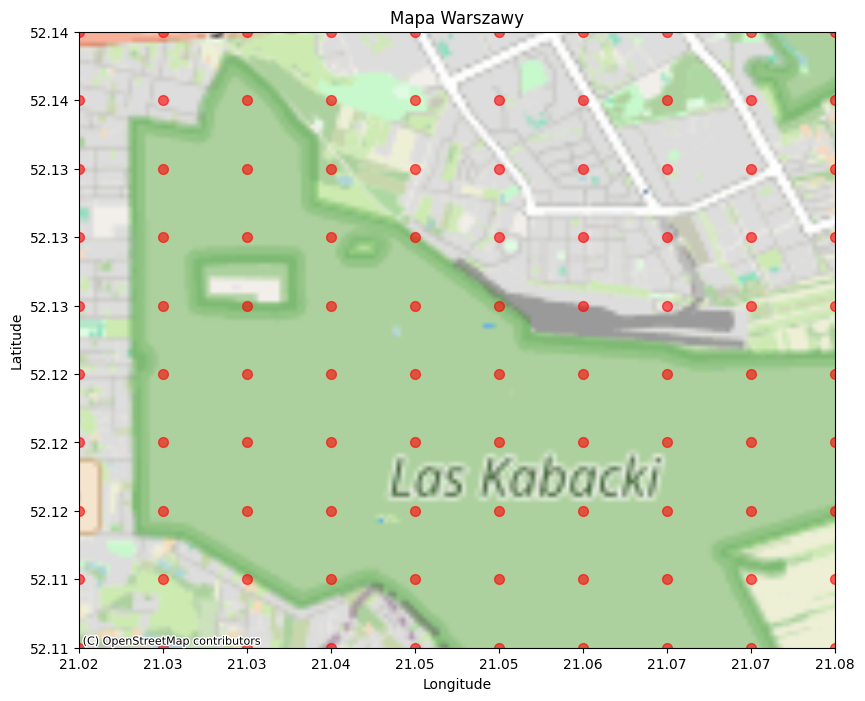

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from shapely.geometry import Point

# Ustalmy rozdzielczość siatki
lat_points = np.linspace(lat_min, lat_max, num=10)
lon_points = np.linspace(lon_min, lon_max, num=10)

# Tworzymy siatkę współrzędnych
grid_points = [(lat, lon) for lat in lat_points for lon in lon_points]

# Tworzymy GeoDataFrame do przechowywania punktów
points = [Point(lon, lat) for lat, lon in grid_points]
gdf = gpd.GeoDataFrame(geometry=points)

# Konwertujemy współrzędne geograficzne na metryczne
gdf = gdf.set_crs("EPSG:4326")
gdf_m = gdf.to_crs(epsg=3857)

# Tworzymy mapę
fig, ax = plt.subplots(figsize=(10, 8))

# Ustawiamy zakres osi
ax.set_xlim([gdf_m.total_bounds[0], gdf_m.total_bounds[2]])
ax.set_ylim([gdf_m.total_bounds[1], gdf_m.total_bounds[3]])

# Dodajemy mapę tła z odpowiednim poziomem zoomu
ctx.add_basemap(ax, crs=gdf_m.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik, zoom=12)

# Dodajemy punkty
gdf_m.plot(ax=ax, color='red', markersize=50, alpha=0.6)

# Dodajemy tytuł i etykiety
plt.title("Mapa Warszawy")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Ustawiamy etykiety osi na współrzędne geograficzne
ax.set_xticks(np.linspace(gdf_m.total_bounds[0], gdf_m.total_bounds[2], num=len(lon_points)))
ax.set_xticklabels(np.round(lon_points, 2))

ax.set_yticks(np.linspace(gdf_m.total_bounds[1], gdf_m.total_bounds[3], num=len(lat_points)))
ax.set_yticklabels(np.round(lat_points, 2))

plt.show()


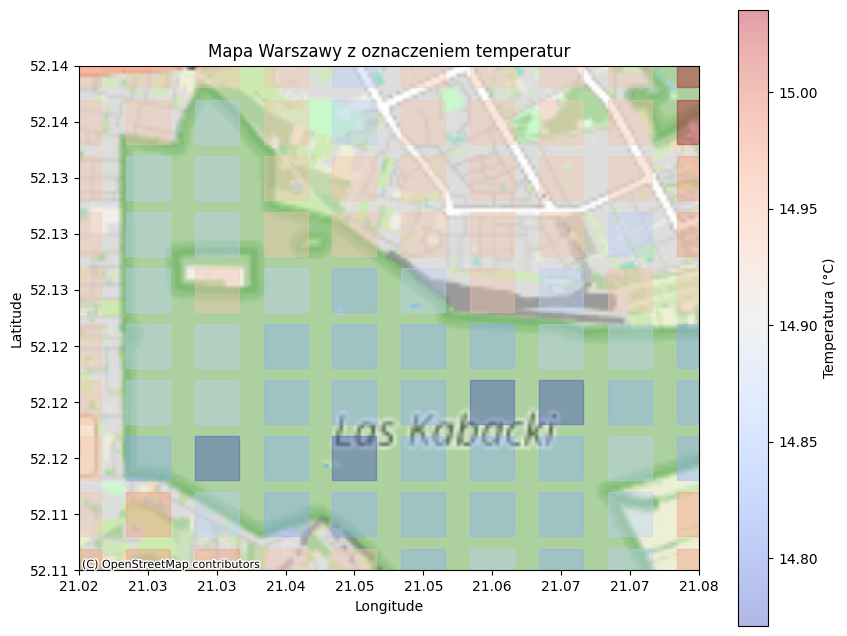

In [24]:
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from shapely.geometry import Point


# Ustalmy rozdzielczość siatki
lat_points = np.linspace(lat_min, lat_max, num=10)
lon_points = np.linspace(lon_min, lon_max, num=10)

# Tworzymy siatkę współrzędnych
grid_points = [(lat, lon) for lat in lat_points for lon in lon_points]

# Tworzymy GeoDataFrame do przechowywania punktów
points = [Point(lon, lat) for lat, lon in grid_points]
gdf = gpd.GeoDataFrame(geometry=points)

# Konwertujemy współrzędne geograficzne na metryczne
gdf = gdf.set_crs("EPSG:4326")
gdf = gdf.to_crs(epsg=3857)

# Tworzymy mapę
fig, ax = plt.subplots(figsize=(10, 8))

# Ustawiamy zakres osi
ax.set_xlim([gdf.total_bounds[0], gdf.total_bounds[2]])
ax.set_ylim([gdf.total_bounds[1], gdf.total_bounds[3]])

# Dodajemy mapę tła z odpowiednim poziomem zoomu
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik, zoom=12)

# Dodajemy punkty z odcieniami kolorów odpowiadającymi temperaturom
temperatures = [average_temperatures[(lat, lon)] for lat, lon in grid_points]
sc = ax.scatter([point.x for point in gdf.geometry], [point.y for point in gdf.geometry], c=temperatures, cmap='coolwarm', s=1000, alpha=0.4, marker='s')

ax.set_xticks(np.linspace(gdf.total_bounds[0], gdf.total_bounds[2], num=len(lon_points)))
ax.set_xticklabels(np.round(lon_points, 2))

ax.set_yticks(np.linspace(gdf.total_bounds[1], gdf.total_bounds[3], num=len(lat_points)))
ax.set_yticklabels(np.round(lat_points, 2))


# Dodajemy legendę
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Temperatura (°C)')

# Dodajemy tytuł i etykiety
plt.title("Mapa Warszawy z oznaczeniem temperatur")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.show()


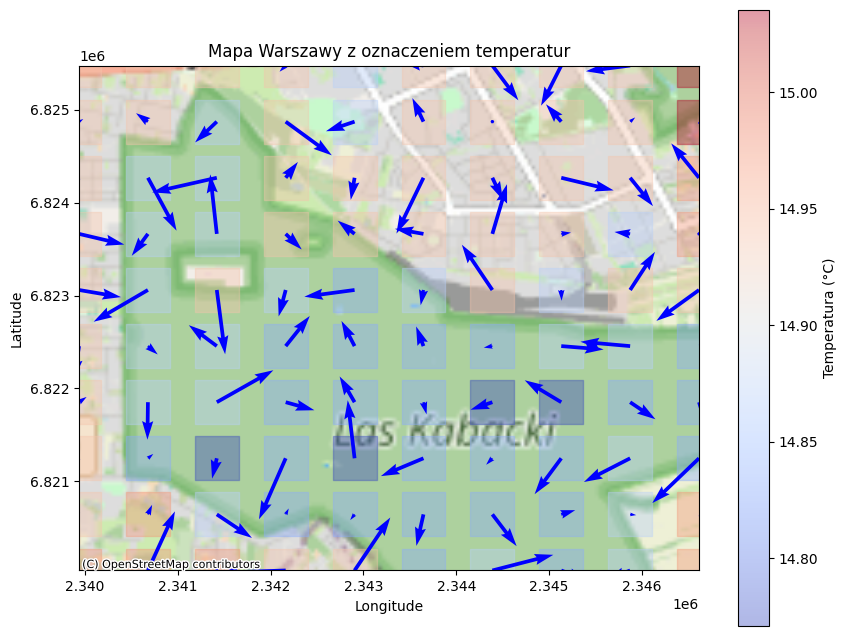

In [25]:
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from shapely.geometry import Point


# Ustalmy rozdzielczość siatki
lat_points = np.linspace(lat_min, lat_max, num=10)
lon_points = np.linspace(lon_min, lon_max, num=10)

# Tworzymy siatkę współrzędnych
grid_points = [(lat, lon) for lat in lat_points for lon in lon_points]

# Tworzymy GeoDataFrame do przechowywania punktów
points = [Point(lon, lat) for lat, lon in grid_points]
gdf = gpd.GeoDataFrame(geometry=points)

# Konwertujemy współrzędne geograficzne na metryczne
gdf = gdf.set_crs("EPSG:4326")
gdf = gdf.to_crs(epsg=3857)

# Tworzymy mapę
fig, ax = plt.subplots(figsize=(10, 8))

# Ustawiamy zakres osi
ax.set_xlim([gdf.total_bounds[0], gdf.total_bounds[2]])
ax.set_ylim([gdf.total_bounds[1], gdf.total_bounds[3]])

# Dodajemy mapę tła z odpowiednim poziomem zoomu
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik, zoom=12)

# Dodajemy punkty z odcieniami kolorów odpowiadającymi temperaturom
temperatures = [average_temperatures[(lat, lon)] for lat, lon in grid_points]
sc = ax.scatter([point.x for point in gdf.geometry], [point.y for point in gdf.geometry], c=temperatures, cmap='coolwarm', s=1000, alpha=0.4, marker='s')

##
wind_directions = np.random.uniform(0, 360, len(grid_points))  # kierunek wiatru w stopniach
wind_speeds = np.random.uniform(0, 10, len(grid_points))  # siła wiatru w m/s

# Skalujemy długość strzałek proporcjonalnie do siły wiatru
scale_factor = 100  # czynnik skali
u = np.cos(np.radians(wind_directions)) * wind_speeds * scale_factor
v = np.sin(np.radians(wind_directions)) * wind_speeds * scale_factor

# Rysujemy strzałki
ax.quiver([point.x for point in gdf.geometry], [point.y for point in gdf.geometry], 
          u, v, color='blue')
##

# Dodajemy legendę
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Temperatura (°C)')

# Dodajemy tytuł i etykiety
plt.title("Mapa Warszawy z oznaczeniem temperatur")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.show()


In [113]:
import openmeteo_requests
import pandas as pd

# lat_min, lat_max = 52.10, 52.16
# lon_min, lon_max = 21.01, 21.13
# lat_min, lat_max = 52.0, 52.4
# lon_min, lon_max = 20.8, 21.3
# Ustawienia granic Polski
lat_min, lat_max = 49, 55  # Szerokość geograficzna
lon_min, lon_max = 14, 24  # Długość geograficzna

# Utwórz klienta Open-Meteo API
openmeteo = openmeteo_requests.Client()

# Ustalmy rozdzielczość siatki
lat_points = np.linspace(lat_min, lat_max, num=10)
lon_points = np.linspace(lon_min, lon_max, num=10)

# Tworzymy siatkę współrzędnych
grid_points = [(lat, lon) for lat in lat_points for lon in lon_points]

# Parametry zapytania
params_template = {
	"start_date": "2024-06-10",
	"end_date": "2024-06-10",
	"hourly": ["temperature_2m", "wind_speed_10m", "wind_direction_10m"]
}
url = "https://archive-api.open-meteo.com/v1/archive"

# Wybierz określoną godzinę lub dzień
#target_time = pd.Timestamp("2024-06-01 12:00:00")

# Dane pogodowe dla każdego punktu siatki
weather_data = []

# Iteracja po punktach siatki
for lat, lon in grid_points:
    params = params_template.copy()
    params["latitude"] = lat
    params["longitude"] = lon

    # Wywołaj API Open-Meteo
    responses = openmeteo.weather_api(url, params=params)
    response = responses[0]  # Pierwsza lokalizacja

    # Wybierz dane dla określonej godziny lub dnia
    hourly_data = response.Hourly()

    # Pobierz dane pogodowe dla określonej godziny lub dnia
    hourly_temperature_2m = hourly_data.Variables(0).ValuesAsNumpy()
    hourly_wind_speed_10m = hourly_data.Variables(1).ValuesAsNumpy()
    hourly_wind_direction_10m = hourly_data.Variables(2).ValuesAsNumpy()

    # Utwórz ramkę danych z danymi pogodowymi
    hourly_data = {
        "latitude": lat,
        "longitude": lon,
        "temperature_2m": hourly_temperature_2m,
        "wind_speed_10m": hourly_wind_speed_10m,
        "wind_direction_10m": hourly_wind_direction_10m
    }
    weather_data.append(hourly_data)

# Konwertuj dane pogodowe na ramkę danych
weather_dataframe = pd.DataFrame(weather_data)

# Wyświetl ramkę danych
weather_dataframe


,latitude,longitude,temperature_2m,wind_speed_10m,wind_direction_10m
0,49.0,14.000000,"[13.4505, 14.6005, 14.3505, 13.900499, 14.4505...","[5.4119864, 5.8048253, 5.00128, 4.3349743, 4.3...","[273.814, 240.2552, 210.25635, 221.63345, 274...."
1,49.0,15.111111,"[14.0615, 15.0615, 14.6115, 14.211499, 14.5114...","[5.506941, 14.84318, 10.538843, 9.007196, 8.22...","[258.6901, 247.1663, 262.1468, 272.29056, 293...."
2,49.0,16.222222,"[14.3815, 17.3815, 16.8315, 16.5315, 16.6315, ...","[4.8433046, 10.24578, 6.489992, 5.8048253, 5.4...","[41.98713, 251.56496, 236.3099, 262.8751, 301...."
3,49.0,17.333333,"[17.5165, 18.1665, 17.8165, 18.2665, 18.216501...","[5.4477882, 7.92, 6.193674, 5.6920996, 5.09116...","[172.40544, 270.0, 215.53777, 198.43504, 188.1..."
4,49.0,18.444444,"[15.394, 15.744, 14.944, 15.094001, 15.244, 15...","[5.8048253, 3.6179552, 7.729527, 12.261158, 1....","[150.2552, 185.7105, 207.75845, 176.6336, 123...."
...,...,...,...,...,...
95,55.0,19.555556,"[15.05, 15.45, 15.55, 15.5, 15.35, 15.15, 15.0...","[18.391737, 13.1041975, 20.393293, 21.2522, 22...","[220.23628, 254.05453, 249.3255, 243.86905, 24..."
96,55.0,20.666667,"[13.15, 12.8, 12.3, 12.2, 13.2, 14.4, 15.8, 16...","[16.09969, 15.84409, 14.587776, 14.512064, 10....","[190.3048, 178.69807, 195.75124, 203.38524, 20..."
97,55.0,21.777778,"[11.172, 10.522, 10.522, 11.022, 12.372, 14.37...","[12.496719, 13.363711, 12.496719, 12.605142, 1...","[168.3664, 152.74475, 168.3664, 178.36346, 185..."
98,55.0,22.888889,"[11.45, 10.35, 10.05, 10.6, 12.15, 14.2, 16.65...","[12.303366, 11.4862, 10.703569, 10.495713, 12....","[159.44388, 147.80429, 160.34608, 174.09395, 1..."


In [114]:
# Wybierz pierwszą wartość prędkości wiatru i kierunku wiatru dla każdego punktu
godz = 12
weather_dataframe['wind_speed'] = weather_dataframe['wind_speed_10m'].apply(lambda x: x[godz])
weather_dataframe['wind_direction'] = weather_dataframe['wind_direction_10m'].apply(lambda x: x[godz])
weather_dataframe['temperatures'] = weather_dataframe['temperature_2m'].apply(lambda x: x[godz])
weather_dataframe


,latitude,longitude,temperature_2m,wind_speed_10m,wind_direction_10m,wind_speed,wind_direction,temperatures
0,49.0,14.000000,"[13.4505, 14.6005, 14.3505, 13.900499, 14.4505...","[5.4119864, 5.8048253, 5.00128, 4.3349743, 4.3...","[273.814, 240.2552, 210.25635, 221.63345, 274....",9.028754,293.498566,17.600500
1,49.0,15.111111,"[14.0615, 15.0615, 14.6115, 14.211499, 14.5114...","[5.506941, 14.84318, 10.538843, 9.007196, 8.22...","[258.6901, 247.1663, 262.1468, 272.29056, 293....",8.311245,287.650208,15.911500
2,49.0,16.222222,"[14.3815, 17.3815, 16.8315, 16.5315, 16.6315, ...","[4.8433046, 10.24578, 6.489992, 5.8048253, 5.4...","[41.98713, 251.56496, 236.3099, 262.8751, 301....",15.546833,312.184357,21.731499
3,49.0,17.333333,"[17.5165, 18.1665, 17.8165, 18.2665, 18.216501...","[5.4477882, 7.92, 6.193674, 5.6920996, 5.09116...","[172.40544, 270.0, 215.53777, 198.43504, 188.1...",12.783802,279.727509,23.966501
4,49.0,18.444444,"[15.394, 15.744, 14.944, 15.094001, 15.244, 15...","[5.8048253, 3.6179552, 7.729527, 12.261158, 1....","[150.2552, 185.7105, 207.75845, 176.6336, 123....",4.802999,282.994629,20.793999
...,...,...,...,...,...,...,...,...
95,55.0,19.555556,"[15.05, 15.45, 15.55, 15.5, 15.35, 15.15, 15.0...","[18.391737, 13.1041975, 20.393293, 21.2522, 22...","[220.23628, 254.05453, 249.3255, 243.86905, 24...",19.803272,297.030792,14.650000
96,55.0,20.666667,"[13.15, 12.8, 12.3, 12.2, 13.2, 14.4, 15.8, 16...","[16.09969, 15.84409, 14.587776, 14.512064, 10....","[190.3048, 178.69807, 195.75124, 203.38524, 20...",22.932877,312.455139,16.000000
97,55.0,21.777778,"[11.172, 10.522, 10.522, 11.022, 12.372, 14.37...","[12.496719, 13.363711, 12.496719, 12.605142, 1...","[168.3664, 152.74475, 168.3664, 178.36346, 185...",15.408671,307.405426,19.172001
98,55.0,22.888889,"[11.45, 10.35, 10.05, 10.6, 12.15, 14.2, 16.65...","[12.303366, 11.4862, 10.703569, 10.495713, 12....","[159.44388, 147.80429, 160.34608, 174.09395, 1...",17.566378,224.169769,21.900000


In [76]:
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from shapely.geometry import Point


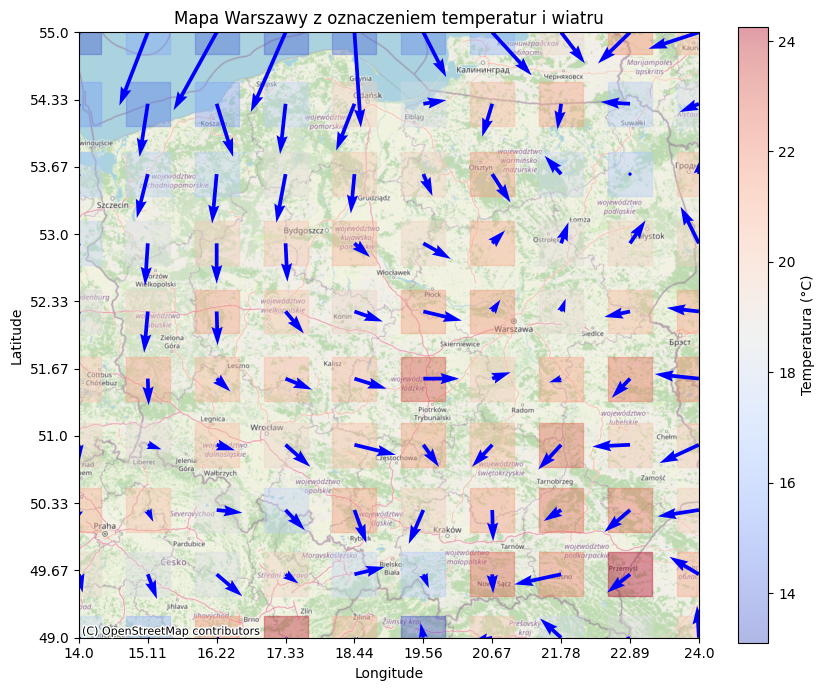

In [115]:
# Ustalmy rozdzielczość siatki
lat_points = np.linspace(lat_min, lat_max, num=10)
lon_points = np.linspace(lon_min, lon_max, num=10)

# Tworzymy siatkę współrzędnych
grid_points = [(lat, lon) for lat in lat_points for lon in lon_points]

# Tworzymy GeoDataFrame do przechowywania punktów
points = [Point(lon, lat) for lat, lon in grid_points]
gdf = gpd.GeoDataFrame(geometry=points)

# Konwertujemy współrzędne geograficzne na metryczne
gdf = gdf.set_crs("EPSG:4326")
gdf = gdf.to_crs(epsg=3857)


# Tworzymy mapę
fig, ax = plt.subplots(figsize=(10, 8))

# Ustawiamy zakres osi
ax.set_xlim([gdf.total_bounds[0], gdf.total_bounds[2]])
ax.set_ylim([gdf.total_bounds[1], gdf.total_bounds[3]])

# Dodajemy mapę tła z odpowiednim poziomem zoomu
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik, zoom=6)

# Dodajemy punkty z odcieniami kolorów odpowiadającymi temperaturom
temperatures = weather_dataframe['temperatures']
sc = ax.scatter([point.x for point in gdf.geometry], [point.y for point in gdf.geometry], c=temperatures, cmap='coolwarm', s=1000, alpha=0.4, marker='s')

##
wind_speeds = weather_dataframe['wind_speed'].tolist()
wind_directions = weather_dataframe['wind_direction'].tolist()

# Skalujemy długość strzałek proporcjonalnie do siły wiatru
scale_factor = 100  # czynnik skali
u = np.cos(np.radians(wind_directions)) * wind_speeds * scale_factor
v = np.sin(np.radians(wind_directions)) * wind_speeds * scale_factor

# Rysujemy strzałki
ax.quiver([point.x for point in gdf.geometry], [point.y for point in gdf.geometry], 
          u, v, color='blue')
##
ax.set_xticks(np.linspace(gdf.total_bounds[0], gdf.total_bounds[2], num=len(lon_points)))
ax.set_xticklabels(np.round(lon_points, 2))

ax.set_yticks(np.linspace(gdf.total_bounds[1], gdf.total_bounds[3], num=len(lat_points)))
ax.set_yticklabels(np.round(lat_points, 2))

# Dodajemy legendę
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Temperatura (°C)')

# Dodajemy tytuł i etykiety
plt.title("Mapa Warszawy z oznaczeniem temperatur i wiatru")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.show()
